# Importing Libraries

In [297]:
import math
import pandas as pd
import numpy as np

from keras import layers
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

import pydot
from kt_utils import *
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [298]:
data = pd.read_csv('train.csv')

In [299]:
data.shape

(42000, 785)

In [300]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Prepare Dataset

### Preprocessing

In [301]:
data.isna().sum().sum()

0

In [302]:
x = data

In [303]:
y = x.pop("label")

In [304]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [305]:
label_mapping = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

### Rescaling

In [306]:
x /= 255

In [307]:
x.shape

(42000, 784)

In [308]:
x.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reshaping

In [309]:
type(x)

pandas.core.frame.DataFrame

In [310]:
x = np.array(x)

In [311]:
type(x)

numpy.ndarray

In [312]:
x = x.reshape(-1, 28, 28, 1)
x.shape

(42000, 28, 28, 1)

### Visualizing Data

In [313]:
sample_data = pd.Series(list(zip(x, y))).sample(9)

sample_X = np.stack(np.array(sample_data.apply(lambda x: x[0])))
sample_y = np.array(sample_data.apply(lambda x: x[1]))

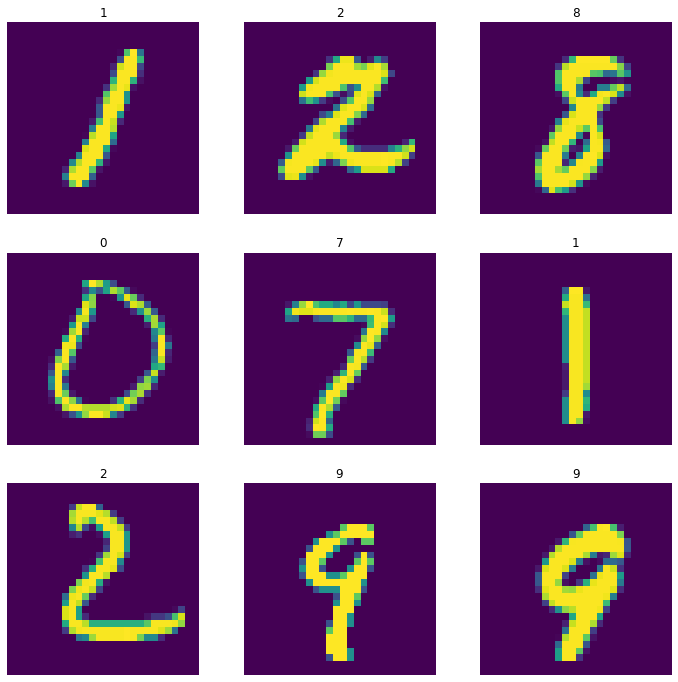

In [314]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(sample_X[i]))
    img_label = label_mapping[sample_y[i]]
    plt.title(img_label)
    plt.axis("off")

plt.show()

### Splitting into Train & Test

In [315]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.7, random_state=123)

In [316]:
Y_train = Y_train.values

In [317]:
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))

In [318]:
Y_test = Y_test.values

In [319]:
Y_test = np.reshape(Y_test, (Y_test.shape[0], 1))

In [320]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 29399
number of test examples = 12601
X_train shape: (29399, 28, 28, 1)
Y_train shape: (29399, 1)
X_test shape: (12601, 28, 28, 1)
Y_test shape: (12601, 1)


# Building the model

In [329]:
def DigitModel(input_shape):
    
    X_input = Input(input_shape)

    X = Sequential()
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2, 2), name='max_pool')(X)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2, 2), name='max_pool2')(X)

    X = Flatten()(X)
    X = Dense(128, activation='relu', name='fc1')(X)
    X = Dropout(0.2)(X)    
    X = Dense(64, activation='relu', name='fc2')(X)
    X = Dropout(0.2)(X)    
    X = Dense(10, activation='softmax', name='output')(X)

    model = Model(inputs = X_input, outputs = X, name='DigitModel')

    return model

### Create the model

In [330]:
digitModel = DigitModel(X_train.shape[1:])

### Compile the model

In [331]:
digitModel.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model

In [332]:
monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, verbose=1, 
                        restore_best_weights=True)

history = digitModel.fit(X_train, Y_train, 
                          validation_split = 0.25, 
                          epochs=18, batch_size=32, 
                          callbacks=[monitor])

Epoch 1/18
690/690 [==============================] - 14s 20ms/step - loss: 0.3797 - accuracy: 0.8793 - val_loss: 0.1037 - val_accuracy: 0.9702
Epoch 2/18
690/690 [==============================] - 12s 18ms/step - loss: 0.1287 - accuracy: 0.9623 - val_loss: 0.0931 - val_accuracy: 0.9739
Epoch 3/18
690/690 [==============================] - 13s 19ms/step - loss: 0.0894 - accuracy: 0.9730 - val_loss: 0.0747 - val_accuracy: 0.9793
Epoch 4/18
690/690 [==============================] - 13s 19ms/step - loss: 0.0748 - accuracy: 0.9764 - val_loss: 0.0548 - val_accuracy: 0.9839
Epoch 5/18
690/690 [==============================] - 15s 22ms/step - loss: 0.0663 - accuracy: 0.9809 - val_loss: 0.0564 - val_accuracy: 0.9842
Epoch 6/18
690/690 [==============================] - 14s 20ms/step - loss: 0.0535 - accuracy: 0.9837 - val_loss: 0.0557 - val_accuracy: 0.9844
Epoch 7/18
690/690 [==============================] - 13s 19ms/step - loss: 0.0496 - accuracy: 0.9850 - val_loss: 0.0502 - val_accuracy:

# Evaluation

In [333]:
preds = digitModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

394/394 [==============================] - 2s 5ms/step - loss: 0.0493 - accuracy: 0.9863

Loss = 0.049310725182294846
Test Accuracy = 0.9862709045410156


In [334]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [335]:
y_true = np.array(Y_test)

y_pred = digitModel.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

In [336]:
clr = classification_report(y_true, y_pred, 
                            target_names=label_mapping.values())

In [337]:
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1229
           1       1.00      0.98      0.99      1412
           2       0.96      0.99      0.98      1245
           3       0.98      0.99      0.99      1268
           4       0.99      0.99      0.99      1211
           5       0.99      0.98      0.99      1190
           6       0.99      0.99      0.99      1271
           7       0.99      0.97      0.98      1298
           8       0.99      0.98      0.99      1237
           9       0.98      0.98      0.98      1240

    accuracy                           0.99     12601
   macro avg       0.99      0.99      0.99     12601
weighted avg       0.99      0.99      0.99     12601



# Submission

In [338]:
test_data = pd.read_csv('test.csv')

In [341]:
test_pred = np.array(test_data/255)
test_pred = test_pred.reshape((-1,28,28,1))

pred = np.argmax(digitModel.predict(test_pred), axis=1)
    
sub_df = {'ImageId':list(range(1, len(test_pred) + 1)),'Label':pred}
submission = pd.DataFrame(sub_df).astype('int')
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [342]:
submission.to_csv('attempt1.csv', index=False)